In [1]:
## initialization 1214

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import constrNMPy
import os 
import warnings

from matplotlib import gridspec
from scipy import sparse, special, stats

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)

# color pallette
[gr,ye,re,bl,pu,ir,ak] = ['#8ECFC9', '#FFBE7A', '#FA7F6F', '#82B0D2','#BEB8DC', '#E7DAD2','#999999']
[vio, grb, lig, sil, aqua] = ['#8c84cf','#6699CC','#66CC99','#C0C0C0','#6db3bc']
# set the style of the plots
az.style.use("arviz-white")

# Model 2: RL with 2-updating processes

之前的模型中，我们假定决策过程是最简单的更新当前state的Q值，但是在存在反馈的情况下，人可以通过fictive learning来更新并没有真实体验的state。

即，当被试以为自己在 subj_state 为 stim: /, pattern: / \ 的 state 0时，如果他做错了，在更新state 0的Q值的同时，也会更新state 1的Q值，即 subj_state 为 stim: /, pattern: / \ 的 state 1。

In [6]:
# Model Modules

def bayesian_percept_per_trial(prior, likelihood_correct, stim_ori):
    """
    Update the prior belief to posterior belief.
    :param prior: [p, 1-p] for 45 and -45
    :param likelihood_correct: usually 0.75
    :param stim_ori: 0 or 1 for 45 and -45
    
    :return: posterior, percept_ori, accuracy and updated prior
    """
    # Likelihood
    if stim_ori == 0:
        likelihood = np.array([likelihood_correct, 1 - likelihood_correct])
    else:
        likelihood = np.array([1 - likelihood_correct, likelihood_correct])
    
    # Calculate the posterior
    posterior = prior * likelihood 
    
    # Normalize the posterior
    posterior = posterior / np.sum(posterior)
    
    # Percept Formation
    percept_ori = np.random.choice([0, 1], p=posterior)
    accuracy = np.array(percept_ori == stim_ori).astype(int)
    
    return likelihood, posterior, percept_ori, accuracy

def attention_fluctuation(base_accuracy=0.75, fluctuation_range=0.1):
    """
    Simulating some trials with attentional flunctuation
    
    :param trial
    :param base_accuracy
    :param fluctuation_range
    
    :return: likelihood_correct after flunctuation
    """
    fluctuation = np.random.uniform(-fluctuation_range, fluctuation_range)
    return max(0, min(1, base_accuracy + fluctuation))

def softmax(x):
    """
    Compute softmax values for each sets of scores in x.
    """
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def RL_Q_decision_per_trial(Q, epsilon, posterior, current_state):
    """
    Run a trial of decision making without update
    :params Q: Q-table
    :params epsilon: exploration rate
    :params posterior: posterior belief of the orientation
    :params current_state: the subject's current state
    
    Returns:
    action in this trial
    resp ori in this trial
    """
    
    # Exploration vs. Exploitation
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.choice([0, 1])  # Exploration: randomly choose a action
    else:
        # Exploitation: choose the best action
        # Using softmax to choose the best action, q = value * posterior
        # posterior is the belief of the orientation
        if current_state in [0, 2]:
            q = Q[current_state] * posterior
        else:
            q = Q[current_state] * (1 - posterior)
            
        action = np.argmax(softmax(q))
        
    action_table = np.array([[0, 1],
                             [1, 0]])
    
    # Response orientation
    if current_state in [0, 2]:
        resp_ori = action_table[0, action]
    else:
        resp_ori = action_table[1, action]
        
    return action, resp_ori

In [111]:
# Model Simulation

def run_trial(stim_ori, 
              prior, likelihood_correct, update_weight, 
              Q, epsilon, learning_rate, discount_factor):
    """
    Run a trial of perceptual decision making, and update the bayesian prior as well as Q-table
    :params stim_ori: stimulus orientation
    :params bayesian: prior, likelihood_correct, update_weight
    :params RL: Q, epsilon, learning_rate, discount_factor
    
    return:
    posterior, percept_ori, accuracy, action, resp_ori, Q
    """
    
    #### Bayesian Perceptual Processing #####
    likelihood, posterior, percept_ori, accuracy = bayesian_percept_per_trial(prior, likelihood_correct, stim_ori)
    
    #### Decision Making #####
    ## deciding current state:
    # Subjective State
    choice_pattern = np.random.choice([0, 1])
    subj_state = 2 * percept_ori + choice_pattern
    actual_state = 2 * stim_ori + choice_pattern
    
    ## Action
    action, resp_ori = RL_Q_decision_per_trial(Q, epsilon, posterior, subj_state)
    
    correctness = np.array(resp_ori == stim_ori).astype(int)
    
    ## Update Based on the Correctness
    # update prior
    if correctness == 0:
        likelihood = np.array([likelihood[1], likelihood[0]])
    updated_prior = prior * likelihood * update_weight + prior * (1 - update_weight)
    updated_prior = updated_prior / np.sum(updated_prior)
    
    # update Q-table
    reward = 1 if correctness == 1 else -1

    Q[subj_state, action] = (1 - learning_rate) * Q[subj_state, action] + learning_rate * (reward + discount_factor * np.max(Q[actual_state]))
    
    return posterior, percept_ori, accuracy, updated_prior, action, resp_ori, Q, subj_state, actual_state, correctness, reward

## Simulation
# Parameters
maxsubj = 30
maxblock = 20
num_trials = 50
# Bayesian Perception
init_prior = np.array([0.5,0.5])
base_accuracy = 0.75
updated_weight = 0.1
lapse_rate = 0.05
# Q Learning
learning_rate = 0.1
discount_factor = 0.7
epsilon = 0.1  # exploration rate
init_Q = np.ones((4, 2)) * 0.5 # 4 states x 2 actions (Choose L or R)

In [159]:
# run 30 subjects, each with 20 blocks, each block has 50 trials

##### Params Setting ########
maxsubj = 30
maxblock = 20
num_trials = 50
# Bayesian Perception
init_prior = np.array([0.5,0.5])
base_accuracy = 0.75
updated_weight = 0
lapse_rate = 0.05
# Q Learning
learning_rate = 0.1
discount_factor = 0
epsilon = 0.1  # exploration rate
init_Q = np.ones((4, 2)) * 0.5 # 4 states x 2 actions (Choose L or R)

all_simulate_data = pd.DataFrame(columns=['subj', 'block', 'trial', 'stim_ori',
                                            'prior/', 'prior\\','percept_ori', 'accuracy', 
                                            'subj_state', 'actual_state', 'action', 
                                            'resp_ori', 'correctness', 'reward'])

for iS in range(1, maxsubj + 1):
    for iB in range(1, maxblock + 1):
        for itest in range(num_trials):
            if itest == 0:
                prior = init_prior
                Q = init_Q
            else:
                prior = updated_prior
            # current stim ori
            stim_ori = np.random.choice([0, 1])
            
            # attention fluctuation
            if np.random.rand() < lapse_rate:
                likelihood_correct = 0.5
            else:
                likelihood_correct = attention_fluctuation(base_accuracy)
            
            # run a trial
            posterior, percept_ori, accuracy, updated_prior, action, resp_ori, Q, subj_state, actual_state, correctness, reward= run_trial(stim_ori, 
                                                                                                                            prior, likelihood_correct, updated_weight, 
                                                                                                                            Q, epsilon, learning_rate, discount_factor)
            
            # save data
            temp_data = pd.DataFrame([[iS, iB, itest, stim_ori,
                                        prior[0], prior[1], percept_ori, accuracy, 
                                        subj_state, actual_state, action, 
                                        resp_ori, correctness, reward]],
                                        columns=['subj', 'block', 'trial', 'stim_ori',
                                                'prior/', 'prior\\','percept_ori', 'accuracy', 
                                                'subj_state', 'actual_state', 'action', 
                                                'resp_ori', 'correctness', 'reward'])
            all_simulate_data = pd.concat([all_simulate_data, temp_data], axis=0)

In [160]:
trial_template = pd.DataFrame(columns=['StimSeq', 'RespOri', 'RespLorR', 'Accuracy', 'ProbeOriLeft', 'ProbeOriRight', 'Qualified'])
all_data = {}

maxsubj = 30
for iS in range(1, maxsubj + 1):
    subject_data = []
    raw_subj = all_simulate_data[all_simulate_data['subj'] == iS]
    for iB in range(1, maxblock + 1):
        block_data = raw_subj[raw_subj['block'] == iB]
        temp_data = trial_template.copy()
        temp_data['StimSeq'] = block_data['stim_ori'].values.copy()
        temp_data['StimSeq'].replace({0: 45, 1: -45}, inplace=True)
        temp_data['RespOri'] = block_data['resp_ori'].values.copy()
        temp_data['RespOri'].replace({0: 45, 1: -45}, inplace=True)
        temp_data['RespLorR'] = block_data['action'].values.copy()
        temp_data['RespLorR'].replace({0: -1, 1: 1}, inplace=True)
        temp_data['Accuracy'] = block_data['correctness'].values.copy()
        temp_data['Accuracy'].astype(int)
        temp_data['ProbeOriLeft'] = block_data['actual_state'].values.copy()
        temp_data['ProbeOriLeft'].replace({0: 45, 2: 45, 1: -45, 3: -45}, inplace=True)
        temp_data['ProbeOriRight'] = block_data['actual_state'].values.copy()
        temp_data['ProbeOriRight'].replace({0: -45, 2: -45, 1: 45, 3: 45}, inplace=True)    
        temp_data['Qualified'] = True
        subject_data.append(temp_data)
    all_data[iS] = subject_data


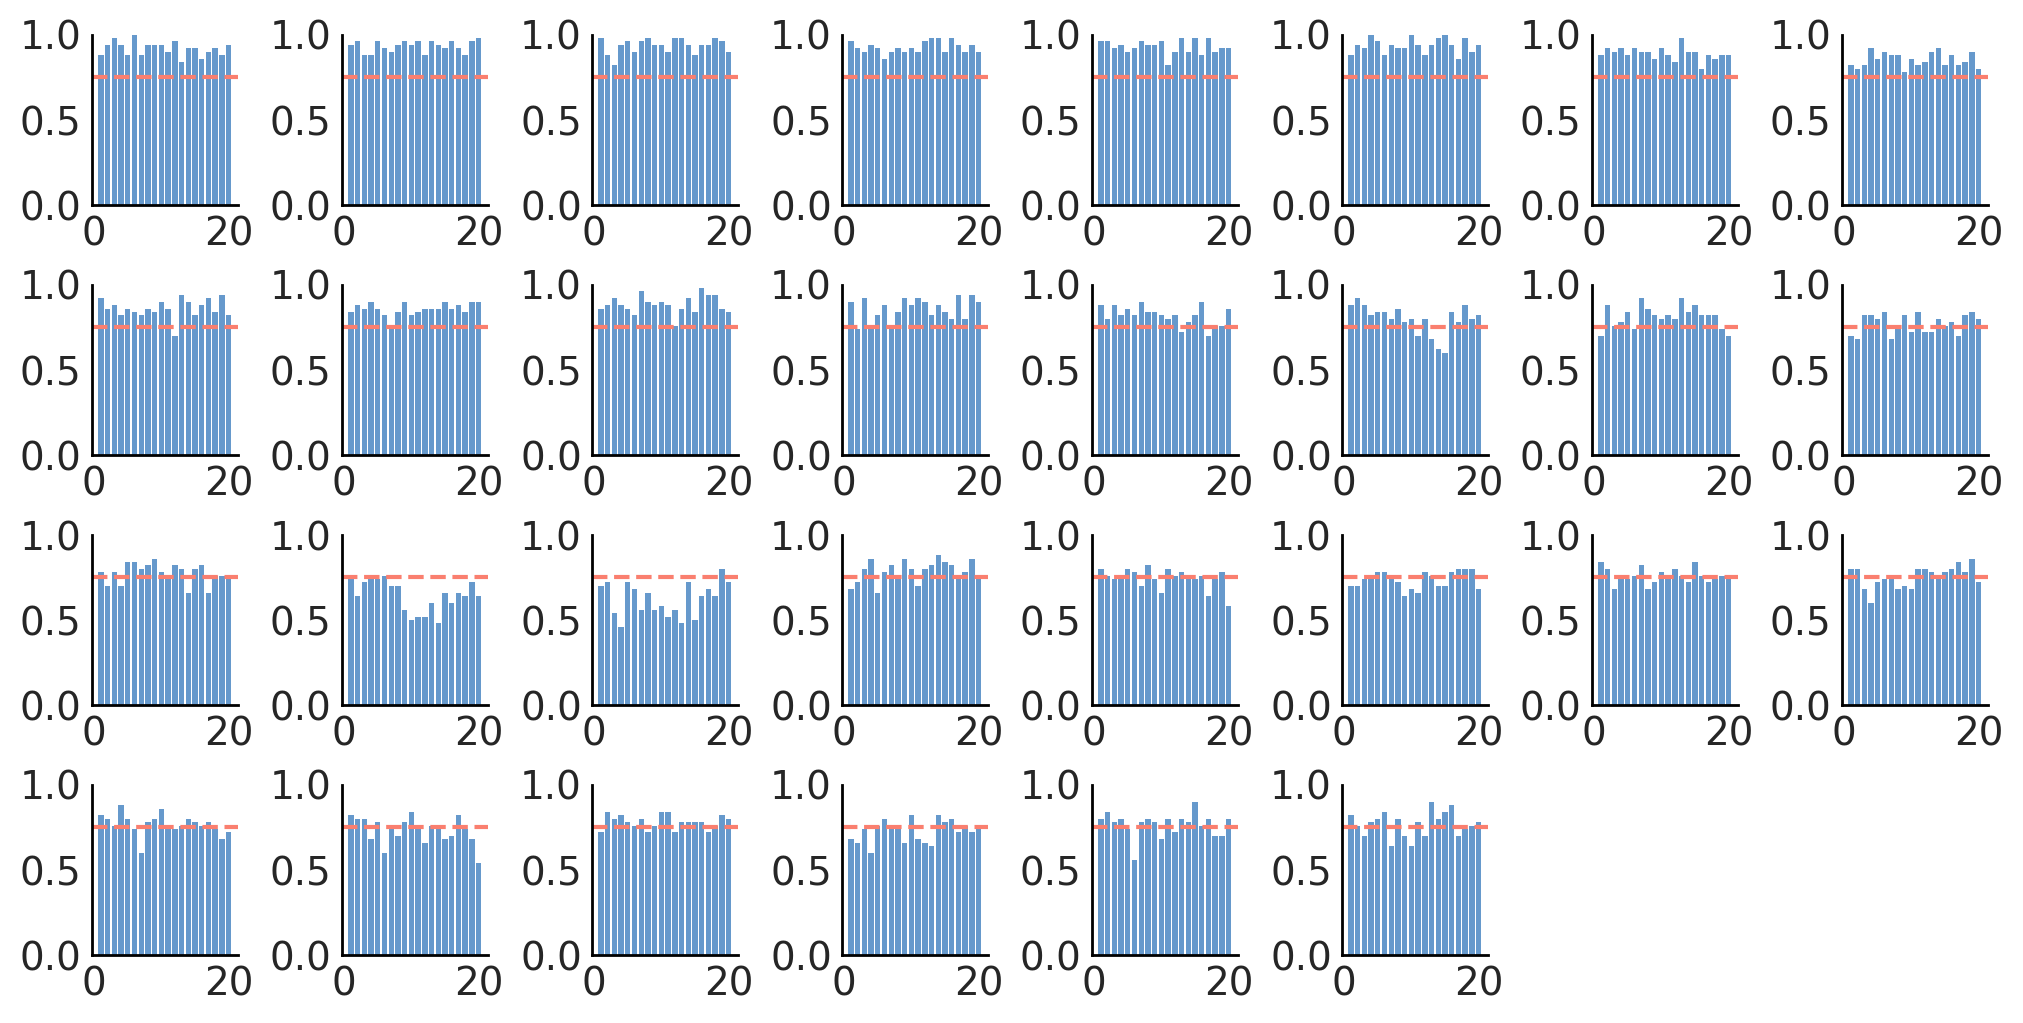

In [161]:
maxsubj = 30; maxblock = 20; maxtrial = 50

plt.figure(figsize=(10, 5))

for iS in range(1, maxsubj + 1):
    subject_data = all_data[iS]  # all blocks for this subject
    temp_accuracy = {f"{i}_block": {} for i in range(1, maxblock + 1)}
    for iB in range(1, maxblock + 1):
        key = f"{iB}_block"
        block_data = subject_data[iB - 1]  # read current block
        temp_accuracy[key] = np.mean(block_data['Accuracy'])
    plt.subplot(4, 8, iS)
    plt.bar([int(i.split('_')[0]) for i in temp_accuracy.keys()], temp_accuracy.values(), color=grb)
    plt.ylim([0, 1])
    plt.axhline(y=0.75, color=re, linestyle='--')

In [162]:
def criterion(hit, FA):
    return -0.5*(stats.norm.ppf(hit) + stats.norm.ppf(FA))

def dprime(hit, FA):
    return (stats.norm.ppf(hit) - stats.norm.ppf(FA))/np.sqrt(2)

def hit_fa(df):
    hit = df[(df['StimSeq'] == 45)]['Accuracy']
    fa = 1 - df[(df['StimSeq'] == -45)]['Accuracy']
    return hit, fa

def hit_fa_motor(df):
    hit = df[(df['StimSeq'] == df['ProbeOriRight'])]['Accuracy']
    fa = 1 - df[(df['StimSeq'] == df['ProbeOriLeft'])]['Accuracy']
    return hit, fa

/var/folders/xc/yqcd0q9s39x5rnx183pvw5qw0000gn/T/ipykernel_44620/1444795699.py:49: RuntimeWarning: invalid value encountered in double_scalars
  SD_back_percept = cri_n45 - cri_45
/var/folders/xc/yqcd0q9s39x5rnx183pvw5qw0000gn/T/ipykernel_44620/2103856392.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return -0.5*(stats.norm.ppf(hit) + stats.norm.ppf(FA))


done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @

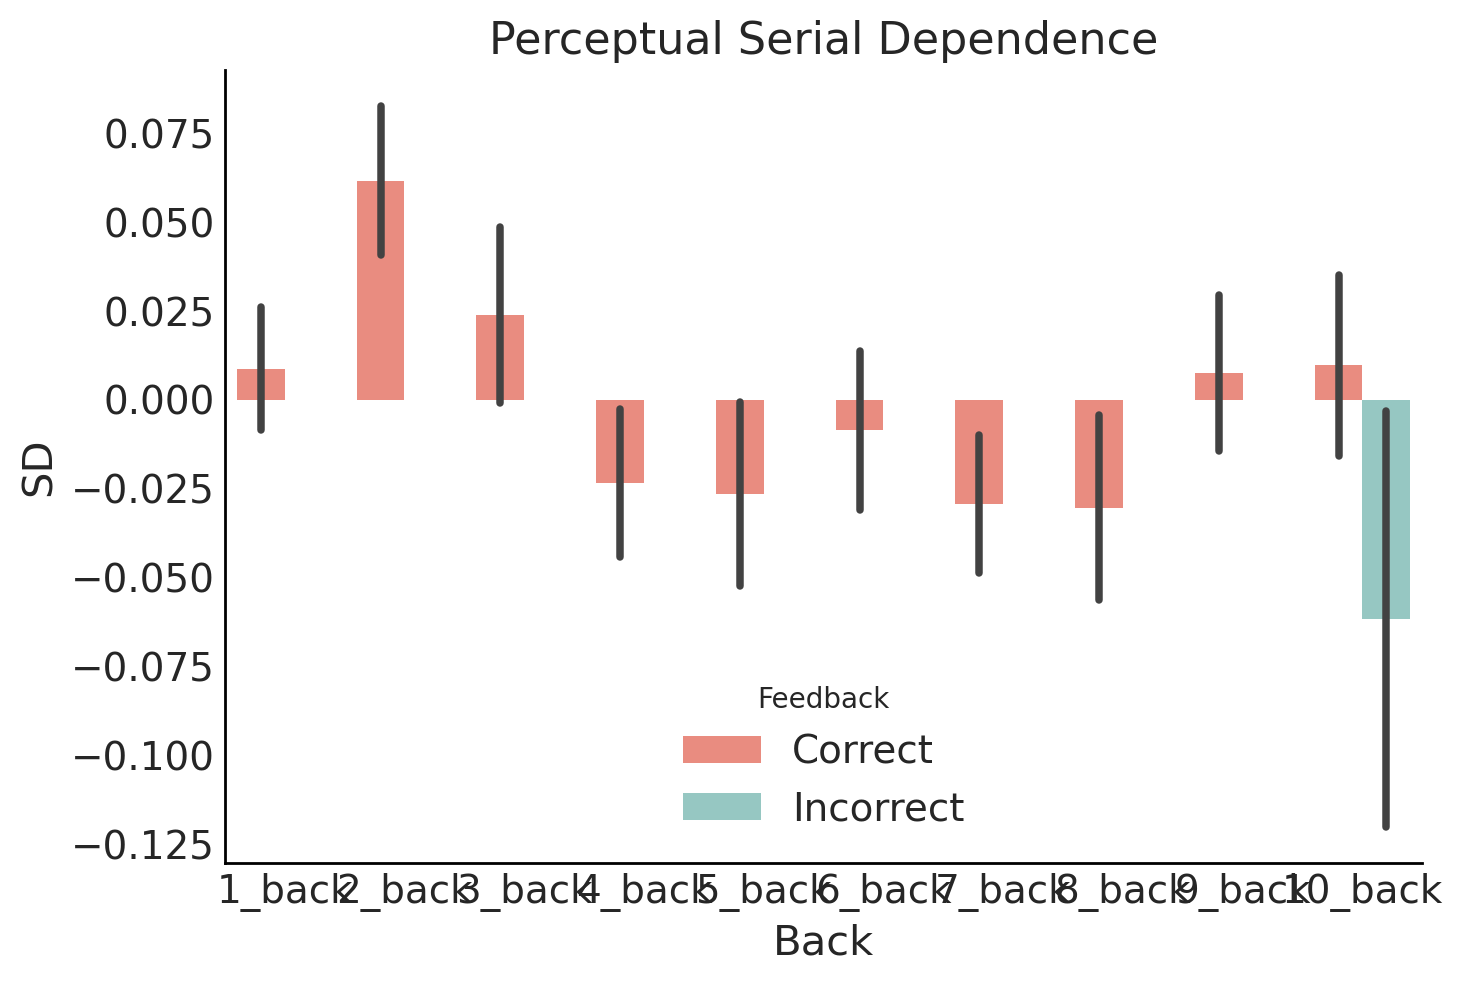

In [163]:
maxsubj = 30; maxblock = 20; maxtrial = 50; num_backs = 10  # n-backs

# Dictionary to store data for different back levels
SD_back_Percept_Y_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)} # 1-10 back, with correct feedback (correct response)
SD_back_Percept_N_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)} # 1-10 back, with incorrect feedback (incorrect response)
criterion_Percept_Y_45_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)} # 1-10 back, with correct feedback (correct response)
criterion_Percept_N_45_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)} # 1-10 back, with incorrect feedback (incorrect response)
criterion_Percept_Y_n45_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)} # 1-10 back, with correct feedback (correct response)
criterion_Percept_N_n45_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)} # 1-10 back, with incorrect feedback (incorrect response)

def process_data_percept_FB_cb(data, back, feedback):
    """Process data and return hits and false alarms"""
    hit, fa = hit_fa(data[(data['RespOri'].shift(back) == 45) & (data['Accuracy'].shift(back) == feedback) & (data['Qualified'] == True)])
    hit_n, fa_n = hit_fa(data[(data['RespOri'].shift(back) == -45) & (data['Accuracy'].shift(back) == feedback) & (data['Qualified'] == True)])
    return (hit, fa, hit_n, fa_n)

FB_types = [1, 0]  # 1: correct feedback; 0: incorrect feedback

for iS in range(1, maxsubj + 1):
    subject_data = all_data[iS]  # Get all block data for the current subject
    
    # Create a temporary dictionary to store data for each back level
    temp_data_Y = {f"{i}_back": {"Hit": [], "FA": [], "Hit_n": [], "FA_n": []} for i in range(1, num_backs + 1)}
    temp_data_N = {f"{i}_back": {"Hit": [], "FA": [], "Hit_n": [], "FA_n": []} for i in range(1, num_backs + 1)}
    temp_data = {1: temp_data_Y, 0: temp_data_N}
    
    for iFB in FB_types:
        feedback = iFB
        for iB in range(1, maxblock + 1):
            block_data = subject_data[iB - 1] # Get data for the current block
            for back in range(1, num_backs + 1):
                hits_fa = process_data_percept_FB_cb(block_data, back, feedback)
                temp_data[feedback][f"{back}_back"]["Hit"].append(hits_fa[0])
                temp_data[feedback][f"{back}_back"]["FA"].append(hits_fa[1])
                temp_data[feedback][f"{back}_back"]["Hit_n"].append(hits_fa[2])
                temp_data[feedback][f"{back}_back"]["FA_n"].append(hits_fa[3])

    # Calculate the criterion score for each back level and add it to SD_back_Percept_Y and SD_back_Percept_N
    for iFB in FB_types:
        feedback = iFB
        for back in range(1, num_backs + 1):
            key = f"{back}_back"
            hits = np.concatenate(temp_data[feedback][key]["Hit"])
            fas = np.concatenate(temp_data[feedback][key]["FA"])
            hits_n = np.concatenate(temp_data[feedback][key]["Hit_n"])
            fas_n = np.concatenate(temp_data[feedback][key]["FA_n"])
            cri_45 = criterion(np.mean(list(hits)), np.mean(list(fas)))
            cri_n45 = criterion(np.mean(list(hits_n)), np.mean(list(fas_n)))
            SD_back_percept = cri_n45 - cri_45
#             temp_output = {'h':format(np.mean(hits),}
#             print(iFB, '_', key, ' :: ', temp_output)
            if feedback == 1:
                SD_back_Percept_Y_cb[key].append(SD_back_percept)
                criterion_Percept_Y_45_cb[key].append(cri_45)
                criterion_Percept_Y_n45_cb[key].append(cri_n45)
            else:
                SD_back_Percept_N_cb[key].append(SD_back_percept)
                criterion_Percept_N_45_cb[key].append(cri_45)
                criterion_Percept_N_n45_cb[key].append(cri_n45)
    print('done ', end="@")

SD_nbacks_Percept_Y_cb = pd.DataFrame(SD_back_Percept_Y_cb)
SD_nbacks_Percept_N_cb = pd.DataFrame(SD_back_Percept_N_cb)
criterion_nbacks_Percept_Y_45_cb = pd.DataFrame(criterion_Percept_Y_45_cb)
criterion_nbacks_Percept_Y_n45_cb = pd.DataFrame(criterion_Percept_Y_n45_cb)
criterion_nbacks_Percept_N_45_cb = pd.DataFrame(criterion_Percept_N_45_cb)
criterion_nbacks_Percept_N_n45_cb = pd.DataFrame(criterion_Percept_N_n45_cb)

SD_nbacks_Percept_N_cb['Feedback'] = 'Incorrect'
SD_nbacks_Percept_Y_cb['Feedback'] = 'Correct'
SD_nbacks_Percept_N_cb['Subject'] = np.arange(1, maxsubj + 1)
SD_nbacks_Percept_Y_cb['Subject'] = np.arange(1, maxsubj + 1)
SD_Percept_FB = pd.concat([SD_nbacks_Percept_Y_cb, SD_nbacks_Percept_N_cb], ignore_index=True)
SD_Percept_FB = SD_Percept_FB.melt(id_vars=['Subject', 'Feedback'], var_name='Back', value_name='SD')

sns.barplot(x='Back', y='SD', hue='Feedback', data=SD_Percept_FB, palette=[re, gr], errorbar='se')
plt.title('Perceptual Serial Dependence')
plt.show()

done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @done @

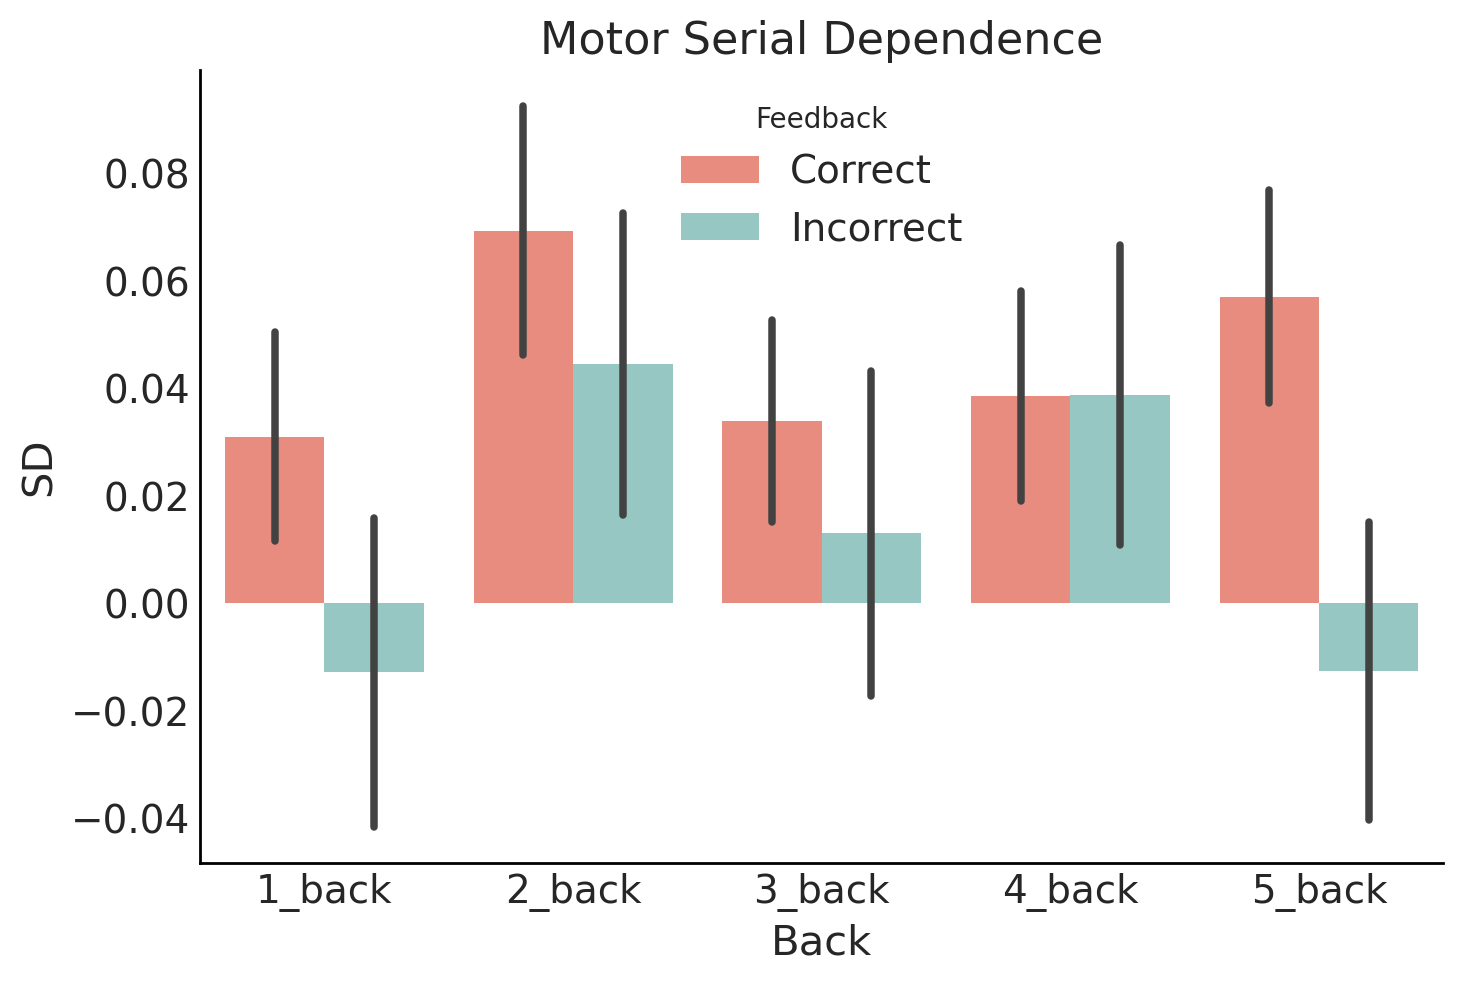

In [149]:
maxsubj = 30 ;maxblock = 20 ;maxtrial = 50 ;num_backs = 5  # 1-back to 10-back

# all data from nbacks
SD_nback_Motor_Y_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)}
SD_nback_Motor_N_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)}
criterion_Motor_Y_L_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)}
criterion_Motor_Y_R_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)}
criterion_Motor_N_L_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)}
criterion_Motor_N_R_cb = {f"{i}_back": [] for i in range(1, num_backs + 1)}

def process_data_motor_FB_cb(data, back, feedback):
    """Process data and return hits and false alarms"""
    hit_l, fa_l = hit_fa_motor(data[(data['RespLorR'].shift(back) == -1) & (data['Accuracy'].shift(back) == feedback) & (data['Qualified'] == True)])
    hit_r, fa_r = hit_fa_motor(data[(data['RespLorR'].shift(back) == 1) & (data['Accuracy'].shift(back) == feedback) & (data['Qualified'] == True)])
    return (hit_l, fa_l, hit_r, fa_r)

FB_types = [1, 0]  # 1: correct feedback; 0: incorrect feedback

for iS in range(1, maxsubj + 1):
    subject_data = all_data[iS]  # Get all block data for the current subject
    
    # Create a temporary dictionary to store data for each back level
    temp_data_Y = {f"{i}_back": {"Hit_L": [], "FA_L": [], "Hit_R": [], "FA_R": []} for i in range(1, num_backs + 1)}
    temp_data_N = {f"{i}_back": {"Hit_L": [], "FA_L": [], "Hit_R": [], "FA_R": []} for i in range(1, num_backs + 1)}
    temp_data = {1: temp_data_Y, 0: temp_data_N}
    
    for iFB in FB_types:
        feedback = iFB
        for iB in range(1, maxblock + 1):
            block_data = subject_data[iB - 1] # Get data for the current block
            for back in range(1, num_backs + 1):
                hits_fa = process_data_motor_FB_cb(block_data, back, feedback)
                temp_data[feedback][f"{back}_back"]["Hit_L"].append(hits_fa[0])
                temp_data[feedback][f"{back}_back"]["FA_L"].append(hits_fa[1])
                temp_data[feedback][f"{back}_back"]["Hit_R"].append(hits_fa[2])
                temp_data[feedback][f"{back}_back"]["FA_R"].append(hits_fa[3])

    # Calculate the criterion score for each back level and add it to SD_back_Percept_Y and SD_back_Percept_N
    for iFB in FB_types:
        feedback = iFB
        for back in range(1, num_backs + 1):
            key = f"{back}_back"
            hits_l = np.concatenate(temp_data[feedback][key]["Hit_L"])
            fas_l = np.concatenate(temp_data[feedback][key]["FA_L"])
            hits_r = np.concatenate(temp_data[feedback][key]["Hit_R"])
            fas_r = np.concatenate(temp_data[feedback][key]["FA_R"])
            cri_l = criterion(np.mean(list(hits_l)), np.mean(list(fas_l)))
            cri_r = criterion(np.mean(list(hits_r)), np.mean(list(fas_r)))
            SD_back_motor = cri_l - cri_r
            if feedback == 1:
                SD_nback_Motor_Y_cb[key].append(SD_back_motor)
                criterion_Motor_Y_L_cb[key].append(cri_l)
                criterion_Motor_Y_R_cb[key].append(cri_r)
            else:
                SD_nback_Motor_N_cb[key].append(SD_back_motor)
                criterion_Motor_N_L_cb[key].append(cri_l)
                criterion_Motor_N_R_cb[key].append(cri_r)
    print('done ', end="@")

SD_nbacks_Motor_Y_cb = pd.DataFrame(SD_nback_Motor_Y_cb)
SD_nbacks_Motor_N_cb = pd.DataFrame(SD_nback_Motor_N_cb)
Criterion_Motor_Y_L_cb = pd.DataFrame(criterion_Motor_Y_L_cb)
Criterion_Motor_Y_R_cb = pd.DataFrame(criterion_Motor_Y_R_cb)
Criterion_Motor_N_L_cb = pd.DataFrame(criterion_Motor_N_L_cb)
Criterion_Motor_N_R_cb = pd.DataFrame(criterion_Motor_N_R_cb)

SD_nbacks_Motor_Y_cb['Feedback'] = 'Correct'
SD_nbacks_Motor_N_cb['Feedback'] = 'Incorrect'
SD_nbacks_Motor_Y_cb['Subject'] = np.arange(1, maxsubj + 1)
SD_nbacks_Motor_N_cb['Subject'] = np.arange(1, maxsubj + 1)
SD_Motor_FB = pd.concat([SD_nbacks_Motor_Y_cb, SD_nbacks_Motor_N_cb], ignore_index=True)
SD_Motor_FB = SD_Motor_FB.melt(id_vars=['Subject', 'Feedback'], var_name='Back', value_name='SD')

sns.barplot(x='Back', y='SD', hue='Feedback', data=SD_Motor_FB, palette=[re, gr], errorbar='se')
plt.title('Motor Serial Dependence')
plt.show()

# Save Progress

In [39]:
import dill
import datetime
path = './Data/'
model_name = 'model_2'
date = datetime.datetime.today().strftime('%Y%m%d')
filename = f'{path}{model_name}_{date}.db'
print(filename)
dill.dump_session(filename)


./Data/model_2_20231220.db


In [2]:
import dill
dill.load_session('./Data/model_2_20231220.db')